# Analysis of A/B Test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns

from scipy.stats import poisson, chi2_contingency
from tqdm.notebook import tqdm
from patsy import dmatrices

import statsmodels.api as sm

import time, datetime

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
PATH= "C:\\Users\\masud.pervez\\Documents\\FS01_DataDump\\Expressen"

In [3]:
# 1..Load data
# Make clients
#client = bigquery.Client.from_service_account_json('C:/Users/maper/Documents/BMB GitHub/r-marketing-engine2/credentials/gcp.json')

# Group Assignments for the A/B test

In [4]:
group_df = pd.read_csv('C:/Users/masud.pervez/Documents/FS01_DataDump/Expressen/AB_Test/group_assingnments.csv', sep=',')
# ab_test_df.group.replace('gör som vanligt', 'control', inplace= True)
group_df.store_id =group_df.store_id.astype('str')
group_df

,Unnamed: 0,store_id,group
0,0,58,test
1,1,98,kontrollgrupp
2,2,130,test
3,3,133,kontrollgrupp
4,4,159,kontrollgrupp
...,...,...,...
5909,5909,30573,kontrollgrupp
5910,5910,32924,kontrollgrupp
5911,5911,64637,kontrollgrupp
5912,5912,4239,kontrollgrupp


In [150]:
# # Levene's Test for Equality of Variances with Python
# #Levene's test centered at the median
# stat, p = levene(group1, group1, center='median') # ‘median’: recommended for skewed distributions.
# print('Statistics= %.3f , pvalue= %.3f' % (stat, p))
# if p > 0.05:
#     print("Groups have equal variances (fail to reject H0)")
# else: 
#     print("The variances between groups are significantly different. (reject H0)")

# Get the sales data from Bigquery

In [5]:
# Using pandas_gbq api

def query_to_dataframe(query, table_schema= None):
    from google.oauth2 import service_account
    import pandas_gbq
    import pandas as pd
    
    credentials = service_account.Credentials.from_service_account_file(
        'G:/Min enhet/BackUp/Documents/credentials/gcp_data_mart.json',
    )

    PROJECT_ID = 'data-mart-xpr'
    
    return pd.read_gbq(query,
                         project_id = PROJECT_ID,
                     credentials= credentials,
                         dialect='standard',
                       progress_bar_type='tqdm')
query= """
    SELECT * 
    FROM `data-mart-xpr.qlikview.upplaga`
    WHERE Edition = 'EX' and Upplagetyp= 'Ordinarie ÅF' and Auto_Man_Bas= 'A'
          and datum BETWEEN '2021-02-01' AND '2021-02-28' /* test period: '2021-02-08' AND '2021-02-21' */
    """


df = query_to_dataframe(query)
print(df.head())

Downloading: 100%|█████████████████████████████████████████████████████████| 163061/163061 [00:32<00:00, 5031.95rows/s]


  UpplagetypKod Magasin Kund_nr Edition Auto_Man_Bas      Datum        Vecka  \
0             A    None   90537      EX            A 2021-02-28  8.000000000   
1             A    None   67428      EX            A 2021-02-24  8.000000000   
2             A    None   90537      EX            A 2021-02-23  8.000000000   
3             A    None   90537      EX            A 2021-02-18  7.000000000   
4             A    None   92731      EX            A 2021-02-20  7.000000000   

  Storleksklass Forsaljningspris    Upplagetyp  ... FSST_nr  \
0             4     30.000000000  Ordinarie ÅF  ...   63767   
1             2     28.000000000  Ordinarie ÅF  ...   32108   
2             3     28.000000000  Ordinarie ÅF  ...   63767   
3             4     28.000000000  Ordinarie ÅF  ...   63767   
4             2     30.000000000  Ordinarie ÅF  ...   23197   

                Butiksnamn      Delfi_Kedja Delfi_Kedjetyp Delfi_Kedjegrupp  \
0      GO BANANA KARLSKOGA  My Way Storkund          Kiosk   

You can add the flag --schema[1] in order to avoid table data information.

bq show --schema --format=prettyjson [PROJECT_ID]:[DATASET].[TABLE] > [SCHEMA_FILE]

bq show --schema --format=prettyjson data-mart-xpr:qlikview.upplaga > ./Documents/myschema.json

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163061 entries, 0 to 163060
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   UpplagetypKod            163061 non-null  object        
 1   Magasin                  0 non-null       object        
 2   Kund_nr                  163061 non-null  object        
 3   Edition                  163061 non-null  object        
 4   Auto_Man_Bas             163061 non-null  object        
 5   Datum                    163061 non-null  datetime64[ns]
 6   Vecka                    163061 non-null  object        
 7   Storleksklass            163061 non-null  object        
 8   Forsaljningspris         163061 non-null  object        
 9   Upplagetyp               163061 non-null  object        
 10  Kedja                    162955 non-null  object        
 11  Prognos                  163061 non-null  float64       
 12  Antal_Salt      

In [35]:
# read from local

# df_qv= pd.read_csv("C:/Users/masud.pervez/Documents/FS01_DataDump/Expressen/AB_Test/qv_data_20210125_20210228.csv", sep=";" , encoding= 'latin1', 
#                parse_dates=['Datum'])
# df_ema= pd.read_csv("C:/Users/masud.pervez/Documents/FS01_DataDump/Expressen/AB_Test/print_sales_data.csv", sep="," )
# df_ema.rename(columns={'store_id': 'FSST-nr', 
#                        'delivered':'Leverans', 
#                        'sold':'Sålt',
#                   'date':'Datum'}, inplace=True)


In [7]:
#df = df_qv.copy()
print(df.shape)
pd.set_option('display.max.columns', None)
df.tail(1)

(163061, 31)


,UpplagetypKod,Magasin,Kund_nr,Edition,Auto_Man_Bas,Datum,Vecka,Storleksklass,Forsaljningspris,Upplagetyp,Kedja,Prognos,Antal_Salt,Intakt,Antal_FSST_Rapp,Antal_Levererat,Antal_Slut,Antal_Returnerat,Slut_procent,Retur_procent,Salt_vs_Prognos_procent,FSST_nr,Butiksnamn,Delfi_Kedja,Delfi_Kedjetyp,Delfi_Kedjegrupp,TestGrupp,Lan,Kommun,A_region,A_region_grupperad
163060,A,None,73421,EX,A,2021-02-03,5.000000000,1,28.000000000,Ordinarie ÅF,Okodade,21200.0,2.000000000,41.479400000,1.000000000,4.000000000,0E-9,2.000000000,0.0,0.5,-0.999906,7338,KUNGSFRUKT,"Servicehandeln,oklassad",Frukt/konfektyr,Övriga,A,Västra Götalands län,TROLLHÄTTAN,TROLLHÄTTAN/VÄNERSBORG,Riks


In [8]:
def weekday_abbreviation(date):
    date= pd.to_datetime(date)
    return ['Må', 'Ti', 'On', 'To', 'Fr', 'Lö', 'Sö'][date.dayofweek]

def preprocess(df):
    df.rename(columns={'Antal_Levererat':'Leverans','Antal_Salt': 'Sålt', 'Intakt': 'Intäkt'}, inplace= True)
    
    #df['FSST_nr'] = df.FSST_nr.astype('int64')
    df['Vecka'] = df.Vecka.astype('int32')
    df['Sålt']= df.Sålt.astype('int32')
    df['Intäkt'] = df.Intäkt.astype('float') 
    #df['Intäkt'] = df['Intäkt'].str.replace(',','').astype('float') 
    df['Leverans']= df['Leverans'].astype('int32')
    df['Retur %'] = 1- (df['Sålt']/df['Leverans'])
    
    return df

# Constants
weekend_price = 28.30   # 30 with moms
weekend_cost = 1.09 # weekend cost is calculated by averaging costs of (Papper, Färg & Övrigt) from different regions. Excluding fixed costs
weekday_price = 26.42  #28 with moms
weekday_cost = 0.94 # weekday cost is calculated by averaging costs of (Papper, Färg & Övrigt) from different regions. Excluding fixed costs

def merge_data(df):
    df['Sold_Out'] = np.where(df['Leverans'] == df['Sålt'], 1,0)
    df = (df.assign( delivery_returned=lambda x: x['Leverans'] - x['Sålt'],
                    dayOfWeek=lambda x: [weekday_abbreviation(w) for w in x['Datum']] ,
                    price=lambda x: x['dayOfWeek'].replace({"Må":weekday_price,"Ti":weekday_price, "On":weekday_price, 
                                                  "To":weekday_price, "Fr":weekend_price, "Lö":weekend_price, 
                                                  "Sö":weekend_price}).astype('float') ,
                    cost=lambda x: x['dayOfWeek'].replace({"Må":weekday_cost,"Ti":weekday_cost, "On":weekday_cost, 
                                                 "To":weekday_cost, "Fr":weekend_cost, "Lö":weekend_cost, 
                                                 "Sö":weekend_cost}).astype('float') ,
                    store_commission=lambda x: x['price']*0.215,
                    profit = lambda x: round((x['Sålt']*(x['price']- x['store_commission'])) - (x['Leverans']*x['cost']), 0),
                    total_cost= lambda x: x['Leverans']*x['cost'] )
    .merge(group_df[['store_id', 'group']], how = 'inner', left_on=['FSST_nr'],right_on=['store_id'])
    .query("Upplagetyp == 'Ordinarie ÅF' and Auto_Man_Bas == 'A' and Sålt >= 0 and Leverans >0") # AutoBas store type
         )
    
    return df

In [9]:
# preprocess data
df= preprocess(df)
# Merge data
df = merge_data(df)

In [366]:
df.sample(10)

,UpplagetypKod,Magasin,Kund_nr,Edition,Auto_Man_Bas,Datum,Vecka,Storleksklass,Forsaljningspris,Upplagetyp,Kedja,Prognos,Sålt,Intäkt,Antal_FSST_Rapp,Leverans,Antal_Slut,Antal_Returnerat,Slut_procent,Retur_procent,Salt_vs_Prognos_procent,FSST_nr,Butiksnamn,Delfi_Kedja,Delfi_Kedjetyp,Delfi_Kedjegrupp,TestGrupp,Lan,Kommun,A_region,A_region_grupperad,Retur %,Sold_Out,delivery_returned,dayOfWeek,price,cost,store_commission,profit,total_cost,store_id,group
142228,A,None,11134,EX,A,2021-02-12,6,3,30.000000000,Ordinarie ÅF,Pressbyrån,28500.0,6,133.2930,1.000000000,12,0E-9,6.000000000,0.0,0.500000,-0.999789,2733,PRESSBYRÅN 4350118,Pressbyrån Franchise,Kiosk,Övriga,B2,Stockholms län,NACKA,STOCKHOLM/SÖDERTÄLJE,Stockholm,0.500000,0,6,Fr,28.30,1.09,6.0845,120.0,13.08,2733,kontrollgrupp
52776,A,None,24549,EX,A,2021-02-23,8,1,28.000000000,Ordinarie ÅF,Okodade,26100.0,1,20.7397,1.000000000,2,0E-9,1.000000000,0.0,0.500000,-0.999962,6865,TRE ANKARE TOBAK,"Servicehandeln,oklassad",Tobaksaffär,Övriga,A,Västra Götalands län,STENUNGSUND,GÖTEBORG,Riks,0.500000,0,1,Ti,26.42,0.94,5.6803,19.0,1.88,6865,test
65302,A,None,76102,EX,A,2021-02-28,8,1,30.000000000,Ordinarie ÅF,Nära Dig,24800.0,2,44.4310,1.000000000,5,0E-9,3.000000000,0.0,0.600000,-0.999919,14941,NÄRA DEJ RONNEBY AB,Handlarn,Servicebutik,Axfood,B,Blekinge län,RONNEBY,KARLSKRONA,Riks,0.600000,0,3,Sö,28.30,1.09,6.0845,39.0,5.45,14941,kontrollgrupp
74338,A,None,65983,EX,A,2021-02-12,6,1,30.000000000,Ordinarie ÅF,Circle K,28500.0,2,44.4310,1.000000000,4,0E-9,2.000000000,0.0,0.500000,-0.999930,13069,CIRCLE K ÄNGELHOLM,Circle K Detaljist,Trafikbutik,Övriga,A,Skåne län,ÄNGELHOLM,ÄNGELHOLM,Riks,0.500000,0,2,Fr,28.30,1.09,6.0845,40.0,4.36,13069,kontrollgrupp
153756,A,None,99654,EX,A,2021-02-19,7,1,30.000000000,Ordinarie ÅF,ICA Nära,28200.0,0,0.0000,1.000000000,3,0E-9,3.000000000,0.0,1.000000,-1.000000,8092,ICA NÄRA HEDEN,ICA Nära,Övrig dagligvarubutik,ICA,A,Västra Götalands län,GÖTEBORG,GÖTEBORG,Riks,1.000000,0,3,Fr,28.30,1.09,6.0845,-3.0,3.27,8092,test
36055,A,None,11262,EX,A,2021-02-20,7,2,30.000000000,Ordinarie ÅF,Shell/7-Eleven,24400.0,3,66.6465,1.000000000,10,0E-9,7.000000000,0.0,0.700000,-0.999877,22990,SHELL VÄLKOMMEN IN,St1,Trafikbutik,Övriga,A,Värmlands län,KARLSTAD,KARLSTAD,Riks,0.700000,0,7,Lö,28.30,1.09,6.0845,56.0,10.90,22990,kontrollgrupp
121107,A,None,74268,EX,A,2021-02-22,8,2,28.000000000,Ordinarie ÅF,Okodade,20600.0,5,103.6985,1.000000000,9,0E-9,4.000000000,0.0,0.444444,-0.999757,841,ÖSTANÅ KIOSK & SERVERING,None,None,None,A,Stockholms län,ÖSTERÅKER,STOCKHOLM/SÖDERTÄLJE,Stockholm,0.444444,0,4,Må,26.42,0.94,5.6803,95.0,8.46,841,kontrollgrupp
20607,A,None,11876,EX,A,2021-02-22,8,1,28.000000000,Ordinarie ÅF,red & Blue,20600.0,0,0.0000,1.000000000,2,0E-9,2.000000000,0.0,1.000000,-1.000000,12223,TEMPO SALLERUP,Tempo,Övrig dagligvarubutik,Axfood,A2,Skåne län,ESLÖV,ESLÖV,Riks,1.000000,0,2,Må,26.42,0.94,5.6803,-2.0,1.88,12223,kontrollgrupp
84351,A,None,84760,EX,A,2021-02-27,8,1,30.000000000,Ordinarie ÅF,Coop,24000.0,1,22.2155,1.000000000,5,0E-9,4.000000000,0.0,0.800000,-0.999958,19669,COOP URVIKEN 23-6202,Coop,Övrig dagligvarubutik,Coop,B2,Västerbottens län,SKELLEFTEÅ,SKELLEFTEÅ,Riks,0.800000,0,4,Lö,28.30,1.09,6.0845,17.0,5.45,19669,test
147936,A,None,72909,EX,A,2021-02-04,5,1,28.000000000,Ordinarie ÅF,Hemköp,22600.0,2,41.4794,1.000000000,5,0E-9,3.000000000,0.0,0.600000,-0.999912,15734,THORS LIVS AB,Hemköp,Dagligvaruhall,Axfood,A,Jönköpings län,SÄVSJÖ,EKSJÖ/NÄSSJÖ/VETLANDA,Riks,0.600000,0,3,To,26.42,0.94,5.6803,37.0,4.70,15734,kontrollgrupp


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Vecka,157771.0,6.500675,1.117615,5.0000,6.000000,7.000000,7.000000,8.000000
Prognos,157771.0,23998.532683,2688.784618,20600.0000,21200.000000,24400.000000,26100.000000,28500.000000
Sålt,157771.0,4.091138,5.307093,0.0000,1.000000,2.000000,5.000000,96.000000
Intäkt,157771.0,87.685051,114.238162,0.0000,20.739700,44.431000,111.077500,2110.472500
Leverans,157771.0,8.752756,7.844095,1.0000,4.000000,7.000000,11.000000,139.000000
Slut_procent,157771.0,0.037561,0.190132,0.0000,0.000000,0.000000,0.000000,1.000000
Retur_procent,157771.0,0.623682,0.269868,0.0000,0.444444,0.625000,0.833333,1.000000
Salt_vs_Prognos_procent,157771.0,-0.999830,0.000217,-1.0000,-0.999960,-0.999903,-0.999764,-0.996065
Retur %,157771.0,0.623682,0.269868,0.0000,0.444444,0.625000,0.833333,1.000000
Sold_Out,157771.0,0.037561,0.190132,0.0000,0.000000,0.000000,0.000000,1.000000


In [11]:
# Aggregate by dates

agg_dates= df.query('Datum >= "2021-02-08" and Datum <= "2021-02-21" ').groupby(['Datum']).agg({'Sålt': sum,
                                      'Sold_Out':sum,
                                      'Leverans':sum,
                                      'Intäkt':sum,
                                      'profit':sum,
                                      'total_cost':sum,
                                      'FSST_nr':'nunique'}).reset_index()

agg_dates= agg_dates.assign(Sold_Out_pct= lambda x: (x['Sold_Out']/x['FSST_nr'])*100,
                                     Retur_pct= lambda x: (1- x['Sålt']/x['Leverans'])*100)
# Aggregate by dates and groups


agg_datesGroup= df.groupby(['Datum', 'group']).agg({  'Sålt': sum,
                                                      'Sold_Out':sum,
                                                      'Leverans':sum,
                                                      'Intäkt':sum,
                                                      'profit':sum,
                                                      'total_cost':sum,
                                                      'FSST_nr':'nunique'}).reset_index()

agg_datesGroup= agg_datesGroup.assign(Sold_Out_pct= lambda x: (x['Sold_Out']/x['FSST_nr'])*100,
                                     Retur_pct= lambda x: (1- x['Sålt']/x['Leverans'])*100)

In [369]:
agg_dates.describe()

,Sålt,Sold_Out,Leverans,Intäkt,profit,total_cost,FSST_nr,Sold_Out_pct,Retur_pct
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,22890.142857,175.214286,51317.428571,490563.072471,438895.071429,51740.293571,5556.000000,3.153454,55.559434
std,3200.081318,12.398378,4521.850876,80255.939907,73212.703105,7683.908774,157.112405,0.201111,2.587975
min,19116.000000,155.000000,45245.000000,396460.105200,351745.000000,42530.300000,5204.000000,2.888534,49.627945
25%,20003.000000,167.250000,47419.250000,414856.219100,370760.750000,44574.095000,5527.750000,2.996453,53.960935
50%,22597.500000,174.000000,52288.000000,502014.761250,445385.000000,52118.300000,5634.500000,3.100495,56.249457
75%,25159.750000,181.500000,54726.500000,537669.712450,483817.000000,57382.232500,5642.250000,3.249651,57.129709
max,29244.000000,198.000000,58316.000000,649670.082000,586656.000000,63564.440000,5648.000000,3.512507,59.658971


In [13]:
agg_datesGroup

,Datum,group,Sålt,Sold_Out,Leverans,Intäkt,profit,total_cost,FSST_nr,Sold_Out_pct,Retur_pct
0,2021-02-01,kontrollgrupp,10186,143,20570,211254.5842,191925.0,19335.80,2844,5.028129,50.481283
1,2021-02-01,test,9921,129,20478,205758.5637,186504.0,19249.32,2795,4.615385,51.552886
2,2021-02-02,kontrollgrupp,12484,116,26643,258914.4148,233834.0,25044.42,2839,4.085946,53.143415
3,2021-02-02,test,12185,88,26248,252713.2445,228026.0,24673.12,2793,3.150734,53.577415
4,2021-02-03,kontrollgrupp,10370,177,20209,215070.6890,196038.0,18996.46,2828,6.258840,48.686229
5,2021-02-03,test,10411,165,20052,215921.0167,197056.0,18848.88,2772,5.952381,48.079992
6,2021-02-04,kontrollgrupp,10309,110,21742,213805.5673,193337.0,20437.48,2835,3.880071,52.584859
7,2021-02-04,test,10308,115,21571,213784.8276,193480.0,20276.74,2785,4.129264,52.213620
8,2021-02-05,kontrollgrupp,13979,122,27354,310550.4745,280836.0,29815.86,2836,4.301834,48.895957
9,2021-02-05,test,14180,145,27201,315015.7900,285481.0,29649.09,2783,5.210205,47.869564


In [15]:
agg_datesGroup.query('Datum >= "2021-02-08" and Datum <= "2021-02-21"').groupby('group').mean()

,Sålt,Sold_Out,Leverans,Intäkt,profit,total_cost,FSST_nr,Sold_Out_pct,Retur_pct
group,,,,,,,,,
kontrollgrupp,11353.928571,108.285714,24003.357143,243363.536764,219171.857143,24240.380714,2795.928571,3.872127,52.799434
test,11536.214286,66.928571,27314.071429,247199.535707,219723.214286,27499.912857,2760.071429,2.425484,57.921743


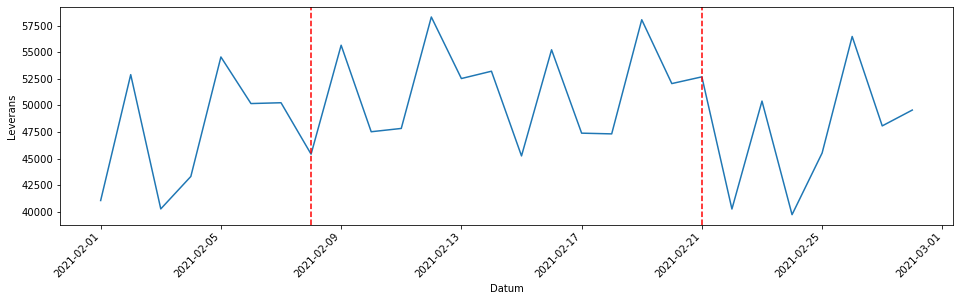

In [44]:
fig= plt.figure(figsize=(16,4))
sns.lineplot(x = 'Datum', y= 'Leverans', data= agg_dates)
plt.xticks(rotation= 45, ha= 'right')
plt.axvline("2021-02-08", color='r', linestyle='dashed')
plt.axvline("2021-02-21", color='r', linestyle='dashed')
plt.show()

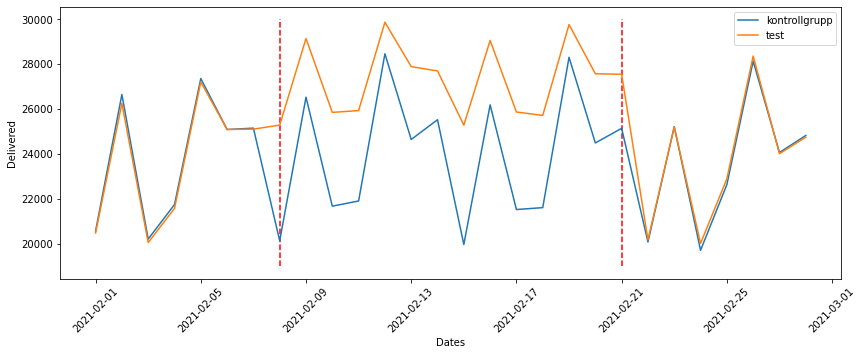

In [372]:
fig, ax = plt.subplots(figsize=(14,5))

sns.lineplot(x = 'Datum', y= 'Leverans', data= agg_datesGroup, hue='group')
ax.set_xlabel("Dates")
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("Delivered")
ax.vlines("2021-02-08",  ymin=19000, ymax=30000, color='r', linestyles='dashed')
ax.vlines("2021-02-21",  ymin=19000, ymax=30000, color='r', linestyles='dashed')
ax.legend()
plt.show()

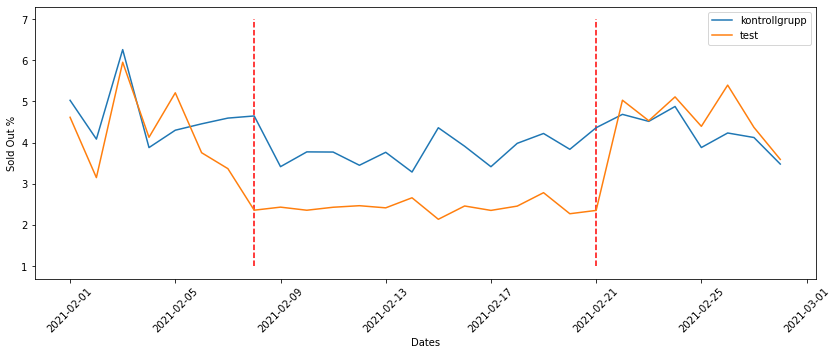

In [373]:
fig, ax = plt.subplots(figsize=(14,5))

sns.lineplot(x = 'Datum', y= 'Sold_Out_pct', data= agg_datesGroup, hue='group')
ax.set_xlabel("Dates")
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("Sold Out %")
ax.vlines("2021-02-08",  ymin=1, ymax=7, color='r', linestyles='dashed')
ax.vlines("2021-02-21",  ymin=1, ymax=7, color='r', linestyles='dashed')
ax.legend()
plt.show()

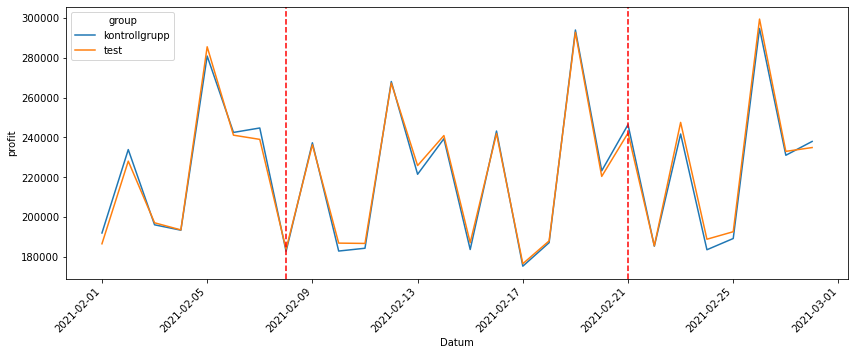

In [374]:
fig= plt.figure(figsize=(14,5))
sns.lineplot(x = 'Datum', y= 'profit', data= agg_datesGroup, hue='group')
plt.xticks(rotation= 45, ha= 'right')
plt.axvline("2021-02-08", color='r', linestyle='dashed')
plt.axvline("2021-02-21", color='r', linestyle='dashed')
plt.show()

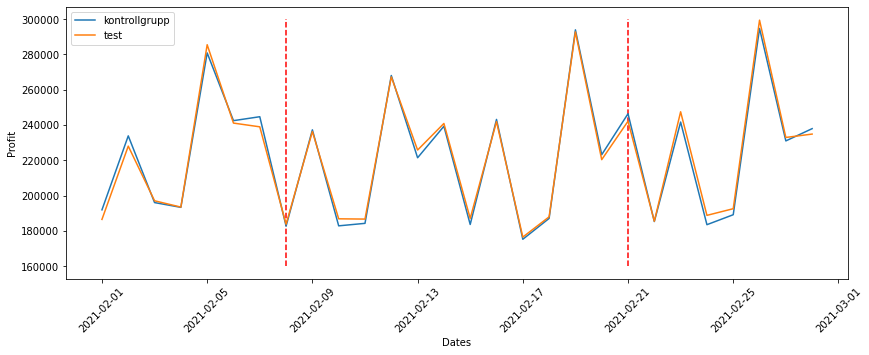

In [375]:
fig, ax = plt.subplots(figsize=(14,5))

sns.lineplot(x = 'Datum', y= 'profit', data= agg_datesGroup, hue='group')
ax.set_xlabel("Dates")
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("Profit")
ax.vlines("2021-02-08",  ymin=160000, ymax=300000, color='r', linestyles='dashed')
ax.vlines("2021-02-21",  ymin=160000, ymax=300000, color='r', linestyles='dashed')
ax.legend()
plt.show()

In [63]:
pivot_result= df.pivot_table(index=['Vecka', 'dayOfWeek'], columns= 'group', 
                     values= 'Leverans', aggfunc='sum').reset_index()

pivot_result['%_diff']= -(1-pivot_result.test/pivot_result.kontrollgrupp)*100
pivot_result.sort_values(by= ['dayOfWeek', 'Vecka'])

group,Vecka,dayOfWeek,kontrollgrupp,test,%_diff
0,5,Fr,27354,27201,-0.559333
7,6,Fr,28455,29861,4.941135
14,7,Fr,28300,29757,5.148410
21,8,Fr,28127,28355,0.810609
1,5,Lö,25084,25087,0.011960
8,6,Lö,24641,27884,13.160992
15,7,Lö,24486,27565,12.574532
22,8,Lö,24061,24009,-0.216117
2,5,Må,20570,20478,-0.447253
9,6,Må,20130,25281,25.588674


In [67]:
pivot_result.query('Vecka == 6 or Vecka == 7')['%_diff'].describe()

count    14.000000
mean     14.550640
std       7.007733
min       4.941135
25%       9.645321
50%      12.867762
75%      19.196828
max      26.610237
Name: %_diff, dtype: float64

In [21]:
def calc_delivery_diff(df):    
    df["control_delivery"] = [np.nan] + df.iloc[:-1]["Leverans"].tolist()
    df["delivery_diff"] = df["Leverans"] - df["control_delivery"]
    df["%delivery_diff"] = ((df["Leverans"] - df["control_delivery"])/df["control_delivery"])*100
    return df

agg_dates= agg_dates.groupby('Datum').apply(calc_delivery_diff)
agg_dates

,Datum,group,Sålt,Sold_Out,Leverans,FSST-nr,control_delivery,delivery_diff,%delivery_diff
0,2021-02-08,control,9826,103,22701,2873,NaN,NaN,NaN
1,2021-02-08,test,10123,105,23242,2875,22701.0,541.0,2.383155
2,2021-02-09,control,12529,89,27650,2873,NaN,NaN,NaN
3,2021-02-09,test,12980,85,28430,2875,27650.0,780.0,2.820976
4,2021-02-10,control,9890,81,23784,2874,NaN,NaN,NaN
5,2021-02-10,test,10307,104,24197,2874,23784.0,413.0,1.736461
6,2021-02-11,control,9939,106,23807,2873,NaN,NaN,NaN
7,2021-02-11,test,10202,73,24413,2874,23807.0,606.0,2.545470
8,2021-02-12,control,13408,91,29064,2873,NaN,NaN,NaN
9,2021-02-12,test,13772,82,29753,2876,29064.0,689.0,2.370630


In [16]:
print('No of stores less than planned for control: {}'.format(ab_test_df.group.value_counts()[0]- merge_df.groupby('group').agg({'FSST_nr': 'nunique'}).reset_index().FSST_nr[0]))
print('No of stores less than planned for test: {}'.format(ab_test_df.group.value_counts()[1]- merge_df.groupby('group').agg({'FSST_nr': 'nunique'}).reset_index().FSST_nr[1]))

No of stores less than planned for control: 125
No of stores less than planned for test: 116


In [19]:
def calc_delivery_diff(df):    
    df["control_delivery"] = [np.nan] + df.iloc[:-1]["Antal_Levererat"].tolist()
    df["delivery_diff"] = df["Antal_Levererat"] - df["control_delivery"]
    df["%delivery_diff"] = ((df["Antal_Levererat"] - df["control_delivery"])/df["control_delivery"])*100
    return df

agg_dates= agg_dates.groupby('Datum').apply(calc_delivery_diff)
agg_dates

,Datum,group,Antal_Salt,Sold_Out,Antal_Levererat,Intakt,FSST_nr,control_delivery,delivery_diff,%delivery_diff
0,2021-02-08,control,9728,101,22451,201755.8016,2820,NaN,NaN,NaN
1,2021-02-08,test,10028,104,22975,207977.7116,2819,22451.0,524.0,2.333972
2,2021-02-09,control,12535,89,27497,259972.1395,2817,NaN,NaN,NaN
3,2021-02-09,test,12826,78,28163,266007.3922,2818,27497.0,666.0,2.422082
4,2021-02-10,control,9810,79,23554,203456.4570,2818,NaN,NaN,NaN
5,2021-02-10,test,10177,97,23969,211067.9269,2816,23554.0,415.0,1.761909
6,2021-02-11,control,9916,107,23651,205654.8652,2821,NaN,NaN,NaN
7,2021-02-11,test,10138,71,24179,210259.0786,2817,23651.0,528.0,2.232464
8,2021-02-12,control,13288,90,28799,295199.5640,2820,NaN,NaN,NaN
9,2021-02-12,test,13669,80,29520,303663.6695,2818,28799.0,721.0,2.503559


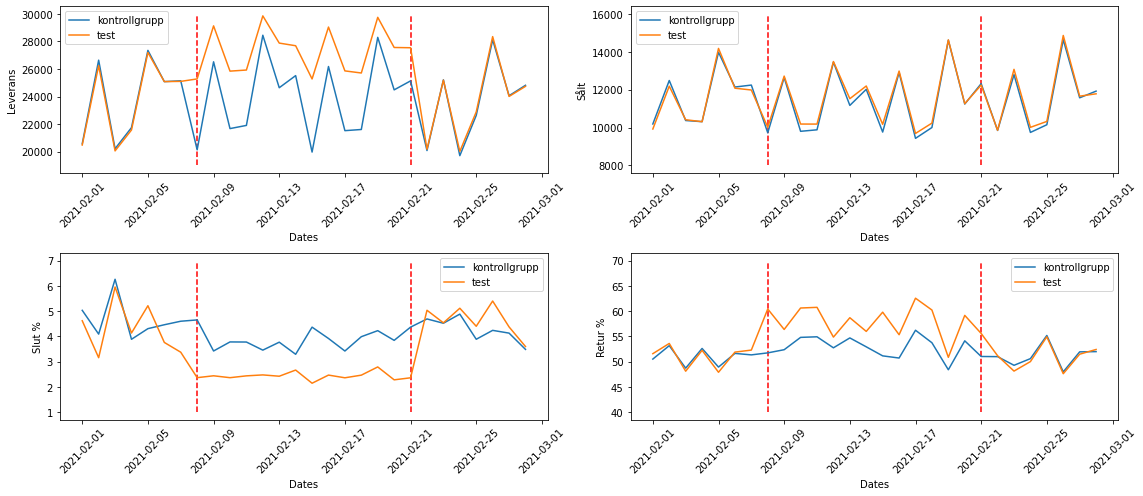

In [16]:
# adding multiple Axes objects  
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2,figsize=(16,7))


# 1st plot
sns.lineplot(x = 'Datum', y= 'Leverans', data= agg_datesGroup, hue='group', ax=ax1)
ax1.set_xlabel("Dates")
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel("Leverans")
ax1.vlines("2021-02-08",  ymin=19000, ymax=30000, color='r', linestyles='dashed')
ax1.vlines("2021-02-21",  ymin=19000, ymax=30000, color='r', linestyles='dashed')
ax1.legend()


#ax1.set_title("Forecast vs delivered", fontsize=14)

# 2nd plot
sns.lineplot(x = 'Datum', y= 'Sålt', data= agg_datesGroup, hue='group', ax=ax2)
ax2.set_xlabel("Dates")
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel("Sålt")
ax2.vlines("2021-02-08",  ymin=8000, ymax=16000, color='r', linestyles='dashed')
ax2.vlines("2021-02-21",  ymin=8000, ymax=16000, color='r', linestyles='dashed')
ax2.legend()


# 3rd plot
sns.lineplot(x = 'Datum', y= 'Sold_Out_pct', data= agg_datesGroup, hue='group', ax=ax3)
ax3.set_xlabel("Dates")
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylabel("Slut %")
ax3.vlines("2021-02-08",  ymin=1, ymax=7, color='r', linestyles='dashed')
ax3.vlines("2021-02-21",  ymin=1, ymax=7, color='r', linestyles='dashed')
ax3.legend()

# 4th plot

sns.lineplot(x = 'Datum', y= 'Retur_pct', data= agg_datesGroup, hue='group', ax=ax4)
ax4.set_xlabel("Dates")
ax4.tick_params(axis='x', rotation=45)
ax4.set_ylabel("Retur %")
ax4.vlines("2021-02-08",  ymin=40, ymax=70, color='r', linestyles='dashed')
ax4.vlines("2021-02-21",  ymin=40, ymax=70, color='r', linestyles='dashed')
ax4.legend()

plt.tight_layout()
#plt.savefig("fig2.png")
plt.show()

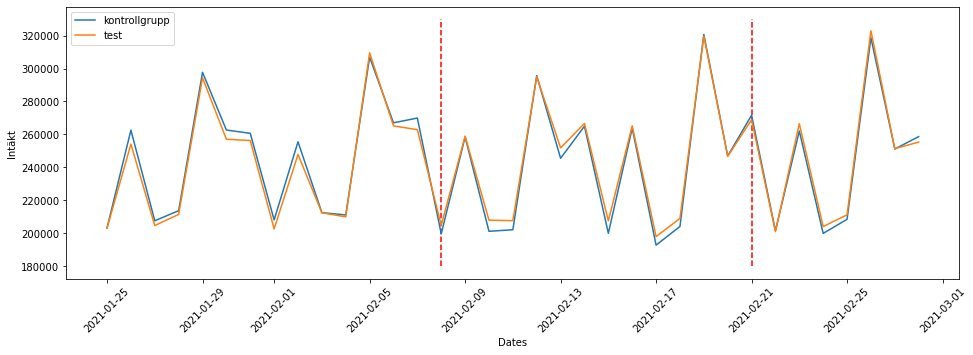

In [104]:
# Intäkt
fig, ax= plt.subplots(figsize=(16,5))
sns.lineplot(x = 'Datum', y= 'Intäkt', data= agg_datesGroup, hue='group')
ax.set_xlabel("Dates")
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("Intäkt")
ax.vlines("2021-02-08",  ymin=180000, ymax=330000, color='r', linestyles='dashed')
ax.vlines("2021-02-21",  ymin=180000, ymax=330000, color='r', linestyles='dashed')
ax.legend()
plt.show()

### Test for sold out (z-test)
    

In [17]:
test_data= df.query('Datum >= "2021-02-08" and Datum <= "2021-02-21" ')

In [18]:
from statsmodels.stats.proportion import proportions_ztest


dates= sorted(test_data.Datum.unique())
dates= pd.to_datetime(dates,format= "%Y-%m-%d")

alpha= 0.05
zscores =[]
p =[]
data = []

for date in dates:
    tmp_df = test_data.loc[test_data.Datum== date]
        #     grp1 = np.array(test_df.loc[test_df.group== 'control', 'Sold_Out'])ignore
#     grp2 = np.array(test_df.loc[test_df.group== 'test', 'Sold_Out'])
    
#     stat, p = ttest_ind(grp1, grp2, equal_var=True)

    metric= np.array([tmp_df.groupby('group')['Sold_Out'].sum()[0], tmp_df.groupby('group')['Sold_Out'].sum()[1]]) # sold out for each group
    n_samples= np.array([tmp_df.groupby('group')['FSST_nr'].count()[0], tmp_df.groupby('group')['FSST_nr'].count()[1]]) # samples for each group

    zscore, p_value =proportions_ztest(metric, n_samples, alternative='two-sided')
    print("Statistics=%.3f, p =%.3f" %(zscore,p_value))
    
    if p_value> alpha:
        print("Same distributions (fail to reject H0)")
    else:
        print("Different distributions (reject H0)")
    zscores.append(zscore)
    p.append(p_value)
    data.append([date, zscore, p_value])
    
resutls_df= pd.DataFrame(data, columns= ['Dates', 'zscores','p'])
resutls_df    

Statistics=4.659, p =0.000
Different distributions (reject H0)
Statistics=2.182, p =0.029
Different distributions (reject H0)
Statistics=3.074, p =0.002
Different distributions (reject H0)
Statistics=2.893, p =0.004
Different distributions (reject H0)
Statistics=2.168, p =0.030
Different distributions (reject H0)
Statistics=2.879, p =0.004
Different distributions (reject H0)
Statistics=1.314, p =0.189
Same distributions (fail to reject H0)
Statistics=4.697, p =0.000
Different distributions (reject H0)
Statistics=3.100, p =0.002
Different distributions (reject H0)
Statistics=2.380, p =0.017
Different distributions (reject H0)
Statistics=3.240, p =0.001
Different distributions (reject H0)
Statistics=2.935, p =0.003
Different distributions (reject H0)
Statistics=3.357, p =0.001
Different distributions (reject H0)
Statistics=4.003, p =0.000
Different distributions (reject H0)


,Dates,zscores,p
0,2021-02-08,4.658768,0.000003
1,2021-02-09,2.181626,0.029137
2,2021-02-10,3.074405,0.002109
3,2021-02-11,2.893370,0.003811
4,2021-02-12,2.167623,0.030187
5,2021-02-13,2.879235,0.003986
6,2021-02-14,1.314268,0.188756
7,2021-02-15,4.697253,0.000003
8,2021-02-16,3.099988,0.001935
9,2021-02-17,2.379783,0.017323


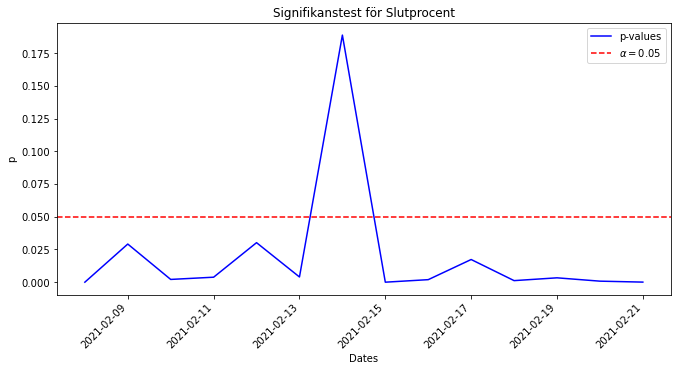

In [19]:
plt.figure(figsize=(11,5))
sns.lineplot(x= 'Dates', y= 'p', data= resutls_df, color= 'blue', label= 'p-values')
#resutls_df.plot(x= 'Dates', y= 'pvalues', kind='line', color= 'blue', figsize=(10,5))
plt.axhline(y=0.05, color='r', linestyle='dashed', label=r'$\alpha = 0.05$')
plt.legend(loc = 'upper right')
plt.xticks(rotation=45, ha='right')
plt.title("Signifikanstest för Slutprocent")
plt.show()

### Test for Delivery (t-test)

In [25]:
from scipy.stats import ttest_ind

dates= sorted(test_data.Datum.unique())
dates= pd.to_datetime(dates,format= "%Y-%m-%d")

alpha= 0.05
stats =[]
p=[]
data = []

for date in dates:
    temp_df = test_data.loc[test_data.Datum== date]
    ctrl = np.array(temp_df.loc[temp_df.group== 'kontrollgrupp', 'Retur %'])
    trt = np.array(temp_df.loc[temp_df.group== 'test', 'Retur %'])
    
    stat, p_value = ttest_ind(ctrl, trt, equal_var=True)

#     metric= np.array([test_df.groupby('group')['Leverans'].sum()[0], test_df.groupby('group')['Leverans'].sum()[1]]) # sold out for each group
#     n_samples= np.array([test_df.groupby('group')['FSST-nr'].count()[0], test_df.groupby('group')['FSST-nr'].count()[1]]) # samples for each group

#     zscore, pvalue =proportions_ztest(metric, n_samples, alternative='two-sided')
    print("Statistics=%.3f, p =%.3f" %(stat,p_value))
    
    if p_value> alpha:
        print("Same distributions (fail to reject H0)")
    else:
        print("Different distributions (reject H0)")
    stats.append(stat)
    p.append(p_value)
    data.append([date, stat, p_value])
    
resutls_df= pd.DataFrame(data, columns= ['Dates', 'stats','p'])
resutls_df    

Statistics=-10.338, p =0.000
Different distributions (reject H0)
Statistics=-5.681, p =0.000
Different distributions (reject H0)
Statistics=-7.401, p =0.000
Different distributions (reject H0)
Statistics=-7.545, p =0.000
Different distributions (reject H0)
Statistics=-3.715, p =0.000
Different distributions (reject H0)
Statistics=-6.518, p =0.000
Different distributions (reject H0)
Statistics=-4.871, p =0.000
Different distributions (reject H0)
Statistics=-10.210, p =0.000
Different distributions (reject H0)
Statistics=-6.512, p =0.000
Different distributions (reject H0)
Statistics=-7.544, p =0.000
Different distributions (reject H0)
Statistics=-9.026, p =0.000
Different distributions (reject H0)
Statistics=-3.504, p =0.000
Different distributions (reject H0)
Statistics=-7.944, p =0.000
Different distributions (reject H0)
Statistics=-7.039, p =0.000
Different distributions (reject H0)


,Dates,stats,p
0,2021-02-08,-10.337506,7.876858e-25
1,2021-02-09,-5.680914,1.405855e-08
2,2021-02-10,-7.400748,1.550051e-13
3,2021-02-11,-7.544581,5.248689e-14
4,2021-02-12,-3.715268,2.049247e-04
5,2021-02-13,-6.517891,7.757627e-11
6,2021-02-14,-4.870576,1.145180e-06
7,2021-02-15,-10.209741,2.890003e-24
8,2021-02-16,-6.511602,8.069290e-11
9,2021-02-17,-7.543985,5.271702e-14


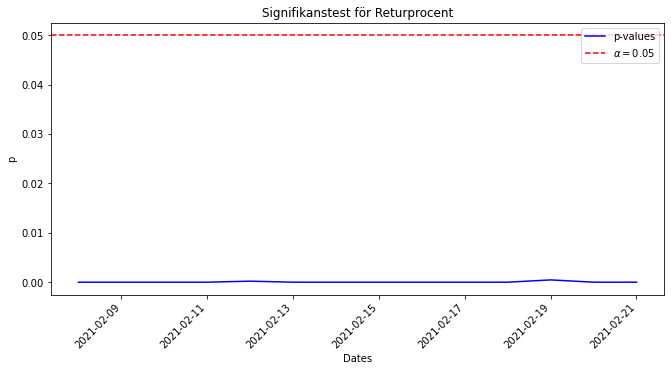

In [26]:
plt.figure(figsize=(11,5))
sns.lineplot(x= 'Dates', y= 'p', data= resutls_df, color= 'blue', label= 'p-values')
#resutls_df.plot(x= 'Dates', y= 'pvalues', kind='line', color= 'blue', figsize=(10,5))
plt.axhline(y=0.05, color='r', linestyle='dashed', label=r'$\alpha = 0.05$')
plt.legend(loc = 'upper right')
plt.xticks(rotation=45, ha='right')
plt.title("Signifikanstest för Returprocent")
plt.show()

H0: Two means are equal
H1: Two means are not equal

In [118]:
def compare_two_groups(array_1, array_2, alpha):
    stat, p = ttest_ind(array_1, array_2)
    print('Statistics= %.3f , pvalue= %.3f' % (stat, p))
    if p > alpha:
        print("Same distributions (fail to reject H0)")
    else: 
        print("Different distributions (reject H0)")

In [120]:
group1 = test_data.loc[test_data.group == 'test']['Sålt']
group2 = test_data.loc[test_data.group == 'kontrollgrupp']['Sålt']

compare_two_groups(group1, group2, alpha=0.05)

Statistics= 3.186 , pvalue= 0.001
Different distributions (reject H0)


we fail to reject H0 which means high CTR observed from experiment group is due to a random chance. The recommendation for a marketing team/product team is not to roll out this new plan/changes.

In [173]:
list_columns= test_df.select_dtypes(include='O').columns
d= {}
for col in list_columns:
    value= len(test_data[col].value_counts().index)
    d[col]= value

# Create dataframe from dic and make keys, index in dataframe
value_count_df = pd.DataFrame.from_dict(d, orient='index')
value_count_df.rename(columns= {0: 'counts'}, inplace=True)
value_count_df.sort_values(by= 'counts', ascending=False)

,counts
Kund_nr,5674
Butiksnamn,5270
Kommun,290
A_region,71
Delfi_Kedja,66
Kedja,48
Antal_Returnerat,47
Lan,21
Delfi_Kedjetyp,17
Storleksklass,10


<Figure size 648x504 with 0 Axes>

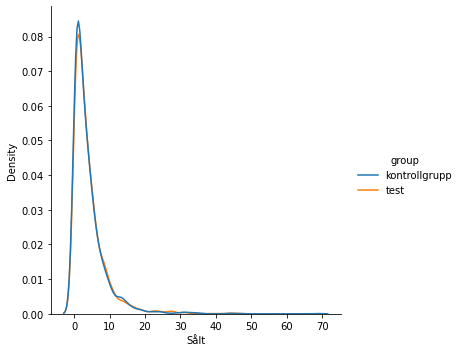

In [49]:
plt.figure(figsize=(9,7))
sns.displot(data= test_data.groupby(['group', 'FSST_nr'])['Sålt'].mean().reset_index(),
            x='Sålt', kind="kde", hue= 'group')
plt.show()

In [43]:
# qcut for equal distribution
test_data['Såltstorleks']=pd.qcut(test_data.groupby(['group', 'FSST_nr'])['Sålt'].transform('mean'), q=10) 

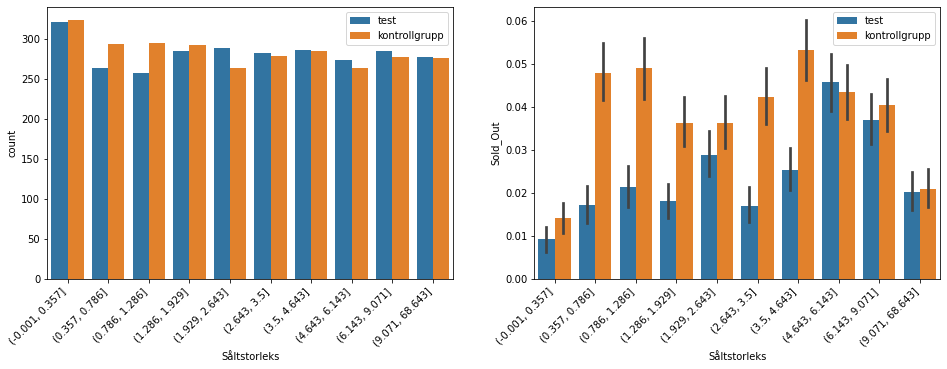

In [48]:
fig, ((ax1, ax2)) = plt.subplots(nrows = 1, ncols = 2,figsize=(16,5))

xlabels= sorted(test_data.Såltstorleks.unique())

# 1st plot
sns.countplot(data= test_data[['group','FSST_nr','Såltstorleks']].drop_duplicates() ,
              x= "Såltstorleks", hue='group',ax= ax1)
#ax1.tick_params(axis='x', rotation=45)
#plt.xticks(rotation=45,ha='right')
ax1.set_xticklabels(xlabels, rotation=45, ha="right")
ax1.legend()


#ax1.set_title("Forecast vs delivered", fontsize=14)

# 2nd plot
sns.barplot(x="Såltstorleks", y="Sold_Out", hue='group', data=test_data, 
                  ax= ax2)
ax2.set_xticklabels(xlabels, rotation = 45, ha= 'right')
#ax2.tick_params(axis='x', rotation=45)
#ax2.tick_params(axis='x', labelrotation = 45, ha= 'right')
ax2.legend()

plt.show()

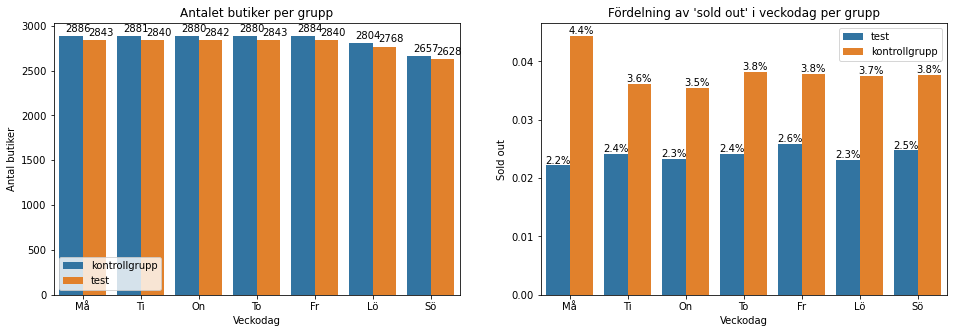

In [52]:
fig, ((ax1, ax2)) = plt.subplots(nrows = 1, ncols = 2,figsize=(16,5))

#xlabels= ['Må', 'Ti','On',  'To', 'Fr',  'Lö', 'Sö' ]

# 1st plot
sns.barplot(data= test_data.groupby(['dayOfWeek', 'group']).agg({'FSST_nr': lambda x: int(x.count()/2)}).reset_index(), 
              x= "dayOfWeek",y= "FSST_nr", hue='group',
              order=['Må', 'Ti','On',  'To', 'Fr',  'Lö', 'Sö'], ax= ax1)
ax1.legend(loc= "lower left")
ax1.set_xlabel("Veckodag")
ax1.set_ylabel("Antal butiker")
ax1.set_title("Antalet butiker per grupp", fontsize=12)
for p in ax1.patches:
        ax1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))


# 2nd plot
sns.barplot(x="dayOfWeek", y="Sold_Out", hue='group', data=test_data, 
            order=['Må', 'Ti','On',  'To', 'Fr',  'Lö', 'Sö'], ax= ax2, ci= None)
ax2.set_xlabel("Veckodag")
ax2.set_ylabel("Sold out")
ax2.set_title("Fördelning av 'sold out' i veckodag per grupp")
ax2.legend()
for p in ax2.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax2.annotate('{:.1f}%'.format(100.*y), (x.mean(), y), 
            ha='center', va='bottom')

plt.show()

In [211]:
#1. all() and any()
#2. chr() and ord()
#3. dir()
#4. enumerate()
#5. eval()
#6. filter()
#7. help()
#8. locals() #this function helps to get variables that had been defined in current Python session (in RAM)
#9. range()
#10. sorted() and reversed()
#11. zip()

True

In [214]:
all([num %2 == 0 for num in [1,2,4, 5, 8,12]])

False

# Further Reading

- [CREATING AN UNBIASED TEST-SET FOR YOUR MODEL USING STRATIFIED SAMPLING TECHNIQUE ](https://blog.usejournal.com/creating-an-unbiased-test-set-for-your-model-using-stratified-sampling-technique-672b778022d5)